In [1]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}
{-# LANGUAGE TypeSynonymInstances #-}
{-# LANGUAGE FlexibleInstances #-}

import Data.Bits             (Bits (bit, complement, popCount, shiftR, (.&.), (.|.)),
                              FiniteBits (finiteBitSize))
import Data.ByteArray.Hash   (FnvHash32 (..), fnv1Hash)
import Data.ByteString.Char8 (pack)
import Data.Char             (intToDigit)
import Data.Semigroup        ((<>))
import Data.Vector           (Vector, drop, singleton, take, (!), (//))
import Data.Word             (Word16, Word32)
import Numeric               (showIntAtBase)
import Prelude               hiding (drop, lookup, take)
import System.TimeIt         (timeIt)
import Text.Show.Pretty      (pPrint)

In [2]:
newtype Binary a = Binary a deriving (Enum, Ord, Real, Integral, Eq, Num, Bits, FiniteBits)

instance (FiniteBits a, Show a, Integral a) => Show (Binary a) where
    show (Binary a) = let
        str = showIntAtBase 2 intToDigit a ""
        size = finiteBitSize a
        in replicate (size - length str) '0' <> str

In [3]:
type Hash = Binary Word32
type Bitmap = Binary Word16
type Shift = Int

class Hashable a where
    hash :: a -> Hash

In [4]:
instance Hashable String where
    hash s = let
        FnvHash32 h = fnv1Hash (pack s)
        in Binary h

In [5]:
data HAMT key value
    = None
    | Leaf Hash key value
    | Many Bitmap (Vector (HAMT key value))
    deriving (Show)

empty :: HAMT key value
empty = None

In [6]:
bitsPerSubkey :: Int
bitsPerSubkey = 4

subkeyMask :: Bitmap
subkeyMask = (bit bitsPerSubkey) - 1

subkey :: Hash -> Shift -> Int
subkey hash shift = fromIntegral $ (fromIntegral $ shiftR hash shift) .&. subkeyMask

maskIndex :: Bitmap -> Bitmap -> Int
maskIndex bitmap mask = popCount (bitmap .&. (mask - 1))

bitMask :: Hash -> Shift -> Bitmap
bitMask hash shift = bit (subkey hash shift)

In [7]:
insertAt :: Vector a -> Int -> a -> Vector a
insertAt vector index a = take index vector <> singleton a <> drop index vector

updateAt :: Vector a -> Int -> a -> Vector a
updateAt vector index a = vector // [(index, a)]

deleteAt :: Vector a -> Int -> Vector a
deleteAt vector index = take index vector <> drop (index+1) vector

In [8]:
insert :: Hashable key => key -> value -> HAMT key value -> HAMT key value
insert key value hamt = insert' 0 (hash key) key value hamt

insert' :: Shift -> Hash -> key -> value -> HAMT key value -> HAMT key value
insert' shift hash key value None = Leaf hash key value

insert' shift hash key value leaf@(Leaf leafHash leafKey leafValue)
    | hash == leafHash = Leaf hash key value
    | otherwise = insert' shift hash key value (Many (bitMask leafHash shift) (singleton leaf))

insert' shift hash key value (Many bitmap vector)
    | bitmap .&. mask == 0 = let
        leaf = Leaf hash key value
        vector' = insertAt vector index leaf
        bitmap' = bitmap .|. mask
        in Many bitmap' vector'
    | otherwise = let
        subtree = vector ! index
        subtree' = insert' (shift+bitsPerSubkey) hash key value subtree
        vector' = updateAt vector index subtree'
        in Many bitmap vector'
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

In [9]:
fromList :: Hashable key => [(key, value)] -> HAMT key value
fromList = foldr (uncurry insert) empty

In [10]:
lookup :: Hashable key => key -> HAMT key value -> Maybe value
lookup key hamt = lookup' 0 (hash key) hamt

lookup' :: Shift -> Hash -> HAMT key value -> Maybe value
lookup' shift hash None = Nothing

lookup' shift hash (Leaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing

lookup' shift hash (Many bitmap vector)
    | bitmap .&. mask == 0 = Nothing
    | otherwise = lookup' (shift+bitsPerSubkey) hash (vector ! index)
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

In [11]:
fibSlow :: Int -> Int
fibSlow 0 = 1
fibSlow 1 = 1
fibSlow n = fibSlow (n-1) + fibSlow (n-2)

In [12]:
instance Hashable Int where
    hash int = Binary (fromIntegral int)

fib' :: HAMT Int Int -> Int -> (Int, HAMT Int Int)
fib' table 0 = (1, insert 0 1 table)
fib' table 1 = (1, insert 1 1 table)
fib' table n = case lookup n table of
    Just i -> (i, table)
    Nothing -> let
        (i1, table')  = fib' table  (n-1)
        (i2, table'') = fib' table' (n-2)
        in (i1 + i2, insert n (i1 + i2) table'')

fibFast :: Int -> Int
fibFast n = fst $ fib' empty n

In [13]:
delete :: Hashable key => key -> HAMT key value -> HAMT key value
delete key hamt = delete' 0 (hash key) hamt

delete' :: Shift -> Hash -> HAMT key value -> HAMT key value
delete' shift hash None = None

delete' shift hash leaf@(Leaf leafHash leafKey leafValue)
    | hash == leafHash = None
    | otherwise = leaf

delete' shift hash many@(Many bitmap vector)
    | bitmap .&. mask == 0 = many
    | otherwise = let
        subtree = vector ! index
        subtree' = delete' (shift+bitsPerSubkey) hash subtree
        in case subtree' of
            None -> if length vector == 1
                then None
                else Many (bitmap .&. complement mask) (deleteAt vector index)
            Leaf{} -> if length vector == 1
                then subtree'
                else Many bitmap (updateAt vector index subtree')
            _ ->     Many bitmap (updateAt vector index subtree')
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

In [14]:
main :: IO ()
main = do
    let example = fromList [("1", 1), ("10", 2), ("100", 3), ("1000", 4)]
    pPrint example
    print $ lookup "100" example
    timeIt $ print $ fibSlow 30
    timeIt $ print $ fibFast 30
    pPrint $ delete "1000" example
    pPrint $ delete "10" $ delete "1000" example

In [15]:
main

Many
  0100010000000000
  [ Many
      0000000100100000
      [ Leaf 00100000011101101010111101011010 "10" 2
      , Leaf 10001010111100101011011010001010 "1000" 4
      ]
  , Many
      0000001000000100
      [ Leaf 00000101000011000101110100101110 "1" 1
      , Leaf 01110100110101100000101010011110 "100" 3
      ]
  ]
Just 3
1346269
CPU time:   1.11s
1346269
CPU time:   0.00s
Many
  0100010000000000
  [ Many
      0000000000100000 [ Leaf 00100000011101101010111101011010 "10" 2 ]
  , Many
      0000001000000100
      [ Leaf 00000101000011000101110100101110 "1" 1
      , Leaf 01110100110101100000101010011110 "100" 3
      ]
  ]
Many
  0100000000000000
  [ Many
      0000001000000100
      [ Leaf 00000101000011000101110100101110 "1" 1
      , Leaf 01110100110101100000101010011110 "100" 3
      ]
  ]

In [16]:
{-# LANGUAGE QuasiQuotes #-}

import IHaskell.Display.Graphviz
import Data.String.Here

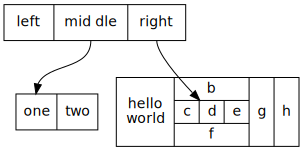

In [17]:
dot [here|
digraph {
  node [shape=record];
  struct1 [label="<f0> left|<f1> mid&#92; dle|<f2> right"];
  struct2 [label="<f0> one|<f1> two"];
  struct3 [label="hello&#92;nworld |{ b |{c|<here> d|e}| f}| g | h"];
  struct1:f1 -> struct2:f0;
  struct1:f2 -> struct3:here;
  }
|]

In [18]:
{-# LANGUAGE BinaryLiterals #-}
{-# LANGUAGE OverloadedLists #-}

t = Many
  0b0100010000000000
  [ Many
      0b0000000100100000
      [ Leaf 0b00100000011101101010111101011010 "10" 2
      , Leaf 0b10001010111100101011011010001010 "1000" 4
      ]
  , Many
      0b0000001000000100
      [ Leaf 0b00000101000011000101110100101110 "1" 1
      , Leaf 0b01110100110101100000101010011110 "100" 3
      ]
  ]

pPrint t

Many
  0100010000000000
  [ Many
      0000000100100000
      [ Leaf 00100000011101101010111101011010 "10" 2
      , Leaf 10001010111100101011011010001010 "1000" 4
      ]
  , Many
      0000001000000100
      [ Leaf 00000101000011000101110100101110 "1" 1
      , Leaf 01110100110101100000101010011110 "100" 3
      ]
  ]

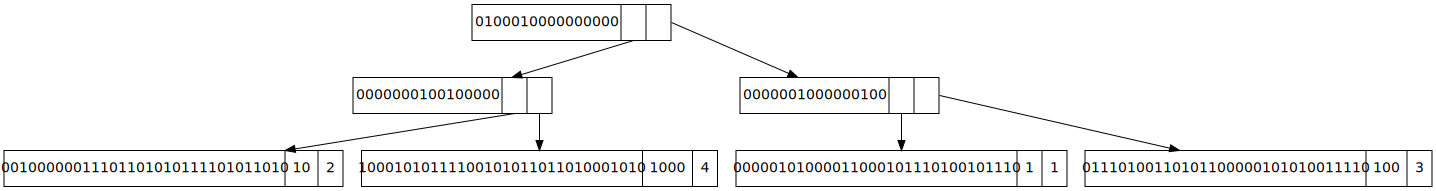

In [19]:
dot [here|
digraph {
  node [shape=record];
  splines=false;
  n0 [label="0100010000000000|<f1>|<f2>"];
  
  n1 [label="0000000100100000|<f1>|<f2>"];
  
  n2 [label="00100000011101101010111101011010|<f1>10|<f2>2"];
  n3 [label="10001010111100101011011010001010|<f1>1000|<f2>4"];
  
  n4 [label="0000001000000100|<f1>|<f2>"];
  
  n5 [label="00000101000011000101110100101110|<f1>1|<f2>1"];
  n6 [label="01110100110101100000101010011110|<f1>100|<f2>3"]

  n0:f1 -> n1;
  n1:f1 -> n2;
  n1:f2 -> n3;
  n0:f2 -> n4;
  n4:f1 -> n5;
  n4:f2 -> n6;
  }
|]

In [20]:
import qualified Data.Map.Strict as Map

data TreeNode
    = TreeNode { nodeId :: Int, bitmap   :: String, fields :: [Int] }
    | LeafNode { leafId :: Int, leafHash :: String, leafKey :: String, leafValue :: String }
    deriving (Eq, Show)

data GraphState = GraphState { counter :: Int, nodes :: [TreeNode] } deriving (Eq, Show)

In [21]:
import Control.Monad.Trans.State.Strict

In [22]:
getFreshId :: State GraphState Int
getFreshId = do
    gs <- get
    put gs { counter = counter gs + 1 }
    pure (counter gs)

prependNode :: TreeNode -> State GraphState ()
prependNode node = do
    gs <- get
    put gs { nodes = node:(nodes gs) }

In [23]:
emptyGraphState = GraphState 0 []

In [24]:
{-# LANGUAGE ScopedTypeVariables #-}

import qualified Data.Vector as Vector

number :: Show a => HAMT String a -> State GraphState Int
number None = error "does not work with empty HAMTs"
number (Leaf h k v) = do
    i <- getFreshId
    prependNode (LeafNode i (show h) k (show v))
    pure i
number (Many b hs) = do
    i <- getFreshId
    numbered <- Vector.toList <$> traverse number hs
    prependNode (TreeNode i (show b) numbered)
    pure i

In [25]:
nodeData = nodes . flip execState emptyGraphState . number

nodeData t

[TreeNode {nodeId = 0, bitmap = "0100010000000000", fields = [1,4]},TreeNode {nodeId = 4, bitmap = "0000001000000100", fields = [5,6]},LeafNode {leafId = 6, leafHash = "01110100110101100000101010011110", leafKey = "100", leafValue = "3"},LeafNode {leafId = 5, leafHash = "00000101000011000101110100101110", leafKey = "1", leafValue = "1"},TreeNode {nodeId = 1, bitmap = "0000000100100000", fields = [2,3]},LeafNode {leafId = 3, leafHash = "10001010111100101011011010001010", leafKey = "1000", leafValue = "4"},LeafNode {leafId = 2, leafHash = "00100000011101101010111101011010", leafKey = "10", leafValue = "2"}]

In [26]:
import Data.List (intercalate, intersperse, foldl')
import qualified Prelude

makeLabel :: ([String], [String]) -> TreeNode -> ([String], [String])
makeLabel (ns,es) (LeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ label ++ "\"]"
    in (line:ns, es)
makeLabel (ns, es) (TreeNode i b fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" $ b:fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ label ++ "\"]"
    in (line:ns,edges++es)

makeLines = foldl' makeLabel ([],[])

ls = makeLines (nodeData t)

In [27]:
makeDotLines :: ([String], [String]) -> String
makeDotLines (ns, es) = let
    nsJoined = intercalate ";\n" ns
    esJoined = intercalate ";\n" es
    in nsJoined ++ ";\n" ++ esJoined ++ ";\n"

putStrLn $ makeDotLines ls

n2 [label="00100000011101101010111101011010|10|2"];
n3 [label="10001010111100101011011010001010|1000|4"];
n1 [label="0000000100100000|<f0>|<f1>"];
n5 [label="00000101000011000101110100101110|1|1"];
n6 [label="01110100110101100000101010011110|100|3"];
n4 [label="0000001000000100|<f0>|<f1>"];
n0 [label="0100010000000000|<f0>|<f1>"];
n1:f0 -> n2;
n1:f1 -> n3;
n4:f0 -> n5;
n4:f1 -> n6;
n0:f0 -> n1;
n0:f1 -> n4;

In [28]:
preamble = unlines $
    [ "digraph {"
    , "node [shape=record];"
    , "splines=false;"
    ]
postamble = unlines $ ["}"]

makeDot :: String -> String
makeDot str = preamble ++ str ++ postamble

In [29]:
dotFromHAMT :: Show a => HAMT String a -> String
dotFromHAMT = makeDot . makeDotLines. makeLines . nodeData

digraph {
node [shape=record];
splines=false;
n2 [label="00100000011101101010111101011010|10|2"];
n3 [label="10001010111100101011011010001010|1000|4"];
n1 [label="0000000100100000|<f0>|<f1>"];
n5 [label="00000101000011000101110100101110|1|1"];
n6 [label="01110100110101100000101010011110|100|3"];
n4 [label="0000001000000100|<f0>|<f1>"];
n0 [label="0100010000000000|<f0>|<f1>"];
n1:f0 -> n2;
n1:f1 -> n3;
n4:f0 -> n5;
n4:f1 -> n6;
n0:f0 -> n1;
n0:f1 -> n4;
}

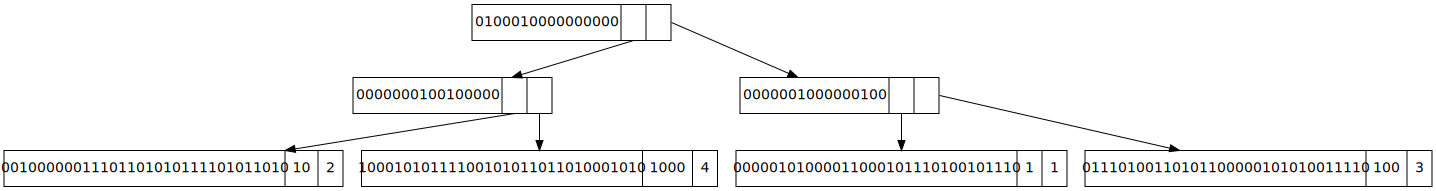

In [30]:
putStrLn $ dotFromHAMT t
dot $ dotFromHAMT t